# ProtonDB Analysis (Cleaned Version)

This notebook loads and analyzes data from the ProtonDB SQLite database.

In [1]:
import pandas as pd
import sqlite3

# Path to your downloaded SQLite file (update if needed)
db_path = "proton_reports.sqlite"

# Connect and read the full 'reports' table
conn = sqlite3.connect(db_path)
df = pd.read_sql_query("SELECT * FROM reports", conn)
conn.close()

# Export to CSV
df.to_csv("protondb_full_reports.csv", index=False)
print("Export complete: protondb_full_reports.csv")


Export complete: protondb_full_reports.csv


## Load CSV and setup

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
import warnings

warnings.filterwarnings('ignore')

# Load the CSV
df = pd.read_csv("protondb_full_reports.csv")
df.shape


(275074, 173)

## Linux Distro Usage

This bar chart shows the distribution of Linux distros used by gamers submitting reports to ProtonDB.

Arch Linux leads, which reflects its popularity among advanced users who prefer full control and are comfortable troubleshooting.

SteamOS has gained a large share due to the success of the Steam Deck, which uses this distro by default.

Mainstream distributions like Ubuntu, Manjaro, and Pop!_OS remain strong options for general-purpose users.

This chart helps us understand which distros are most commonly used in the Linux gaming community and can also hint at the relative compatibility and support these systems provide.


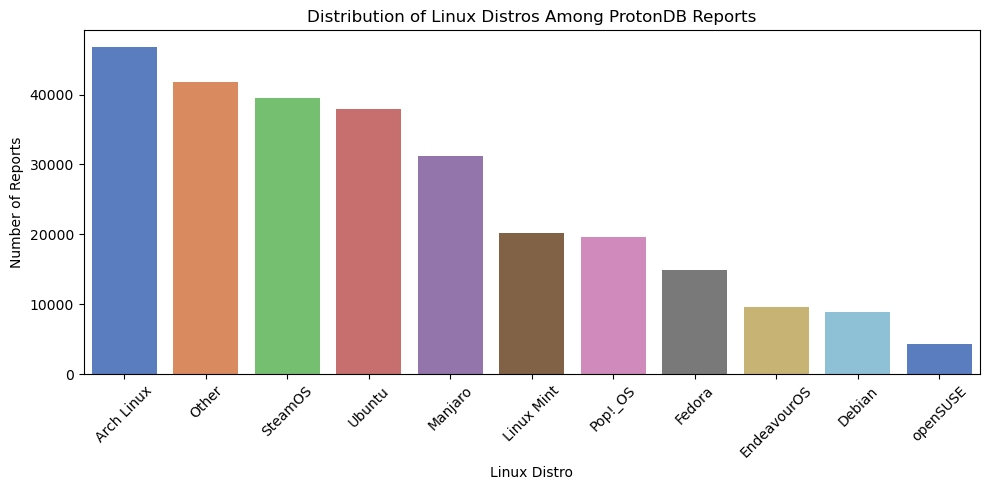

In [4]:
def categorize_os(os):
    os = str(os).lower()
    if "arch" in os:
        return "Arch Linux"
    elif "ubuntu" in os:
        return "Ubuntu"
    elif "debian" in os:
        return "Debian"
    elif "fedora" in os:
        return "Fedora"
    elif "manjaro" in os:
        return "Manjaro"
    elif "opensuse" in os:
        return "openSUSE"
    elif "pop!_os" in os:
        return "Pop!_OS"
    elif "mint" in os:
        return "Linux Mint"
    elif "steamos" in os or "holo" in os:
        return "SteamOS"
    elif "endeavouros" in os:
        return "EndeavourOS"
    else:
        return "Other"

df['os_family'] = df['systemInfo.os'].dropna().apply(categorize_os)
os_counts = df['os_family'].value_counts()

plt.figure(figsize=(10, 5))
sns.barplot(x=os_counts.index, y=os_counts.values, palette="muted")
plt.title("Distribution of Linux Distros Among ProtonDB Reports")
plt.xlabel("Linux Distro")
plt.ylabel("Number of Reports")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## GPU Vendor vs Linux Distro (Heatmap)

This heatmap visualizes the relationship between GPU vendors (AMD, NVIDIA, Intel) and Linux distributions.

SteamOS is almost entirely AMD, reflecting the Steam Deck’s hardware.

Arch Linux and Ubuntu show strong use of both AMD and NVIDIA, indicating these are common setups for users customizing their systems.

Intel GPUs appear much less frequently and are usually paired with Ubuntu or Mint, likely due to older or integrated hardware.

This chart helps us see where each GPU vendor is most popular and can highlight where support might be strongest.


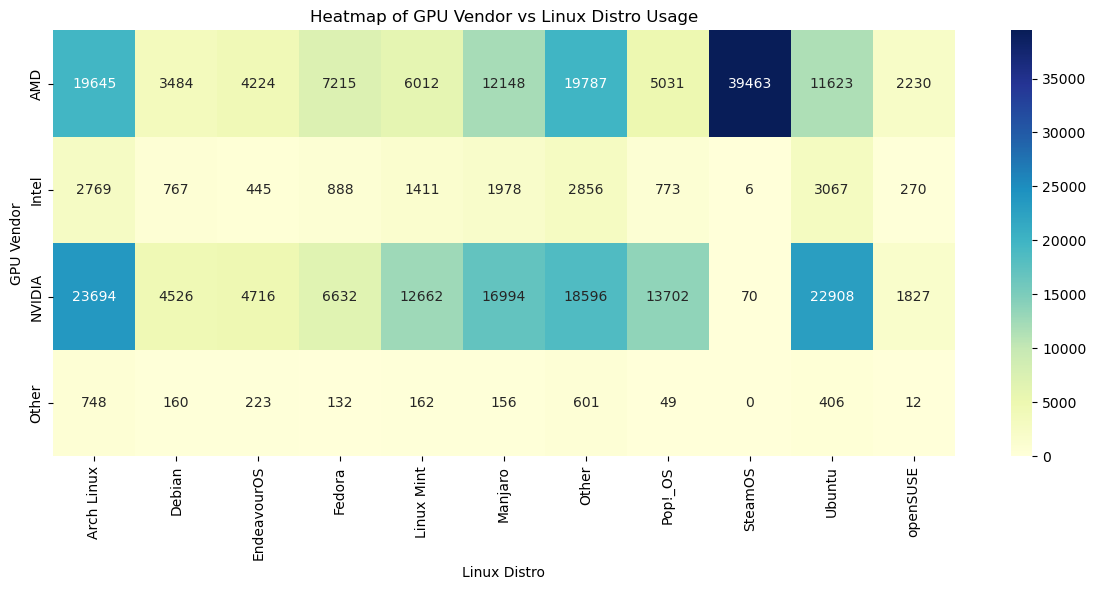

In [5]:
def categorize_gpu(gpu):
    gpu = str(gpu).lower()
    if "nvidia" in gpu:
        return "NVIDIA"
    elif "amd" in gpu or "radeon" in gpu:
        return "AMD"
    elif "intel" in gpu:
        return "Intel"
    else:
        return "Other"

df['gpu_vendor'] = df['systemInfo.gpu'].dropna().apply(categorize_gpu)

heatmap_df = df[df['os_family'].notnull() & df['gpu_vendor'].notnull()]
heatmap_data = heatmap_df.pivot_table(index="gpu_vendor", columns="os_family", aggfunc="size", fill_value=0)

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Heatmap of GPU Vendor vs Linux Distro Usage")
plt.xlabel("Linux Distro")
plt.ylabel("GPU Vendor")
plt.tight_layout()
plt.show()


## Sentiment Over Time

This line chart shows how the average sentiment in ProtonDB user notes has changed month to month.

We measure sentiment using NLP to extract polarity scores from user-submitted notes. Scores range from -1 (very negative) to +1 (very positive).

The clear upward trend shows that user experience is improving, likely thanks to updates in Proton, driver improvements, and better game support.

Occasional dips may correspond to major regressions or problematic updates.


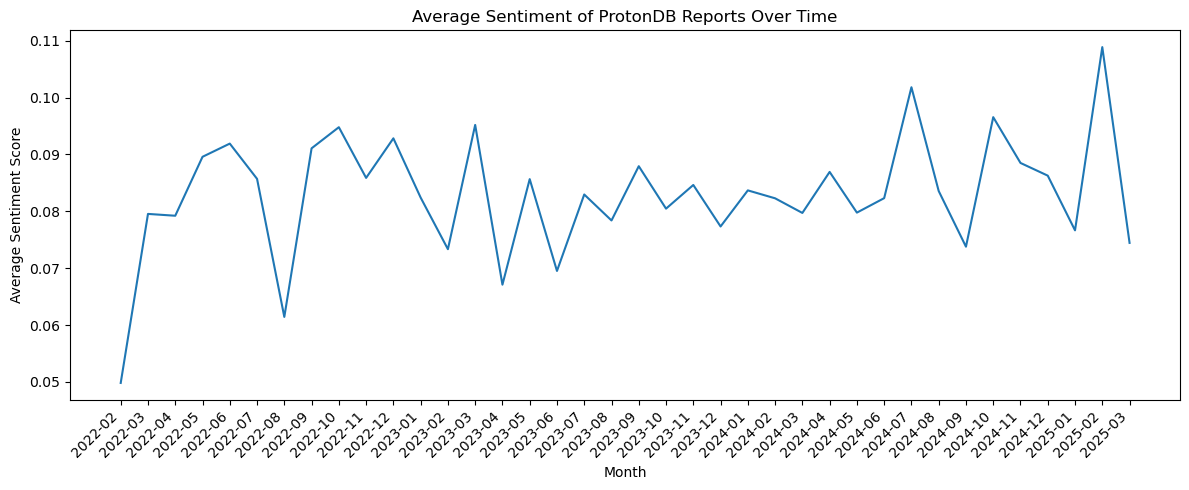

In [6]:
notes_df = df[df['responses.concludingNotes'].notnull()][['timestamp', 'responses.concludingNotes']].copy()
notes_df['date'] = pd.to_datetime(notes_df['timestamp'], unit='s')
notes_df['year_month'] = notes_df['date'].dt.to_period("M")
notes_df['sentiment'] = notes_df['responses.concludingNotes'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)

monthly_sentiment = notes_df.groupby("year_month")["sentiment"].mean().reset_index()
monthly_sentiment["year_month"] = monthly_sentiment["year_month"].astype(str)

plt.figure(figsize=(12, 5))
sns.lineplot(data=monthly_sentiment, x="year_month", y="sentiment")
plt.title("Average Sentiment of ProtonDB Reports Over Time")
plt.xlabel("Month")
plt.ylabel("Average Sentiment Score")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


## Game Specific OS & GPU Chart

The following charts break down which combinations of OS and GPU vendors users are running for specific games:

Cyberpunk 2077: Heavily favors Arch Linux and NVIDIA users — likely because it's demanding and benefits from tweaking.

No Man’s Sky: More balanced between AMD/NVIDIA and across distros, suggesting good out-of-the-box compatibility.

Skyrim and The Witcher 3: Both see strong adoption on Arch, Manjaro, and Ubuntu. The modding community likely plays a role here.

Elden Ring: Fewer data points, but shows a trend toward NVIDIA and Arch setups.

These charts give a ground-level look at what real-world users are relying on to play high-profile titles on Linux.


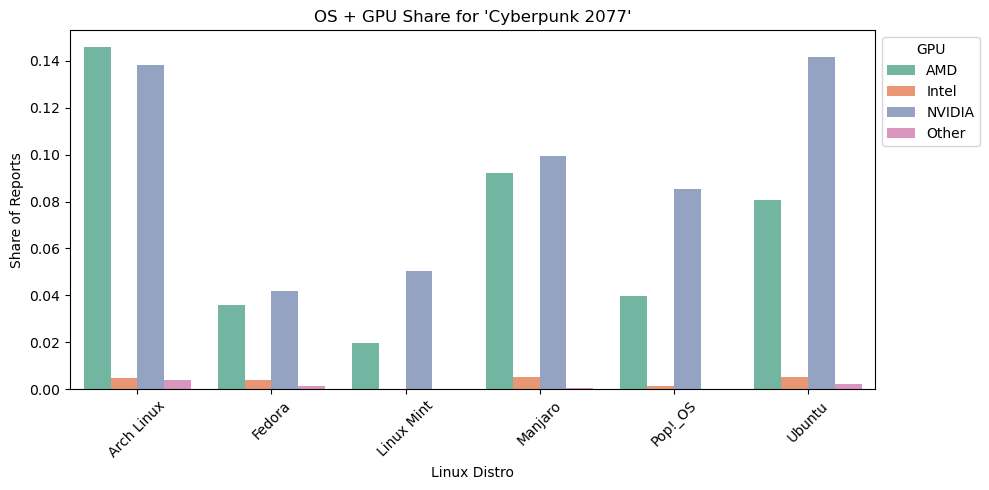

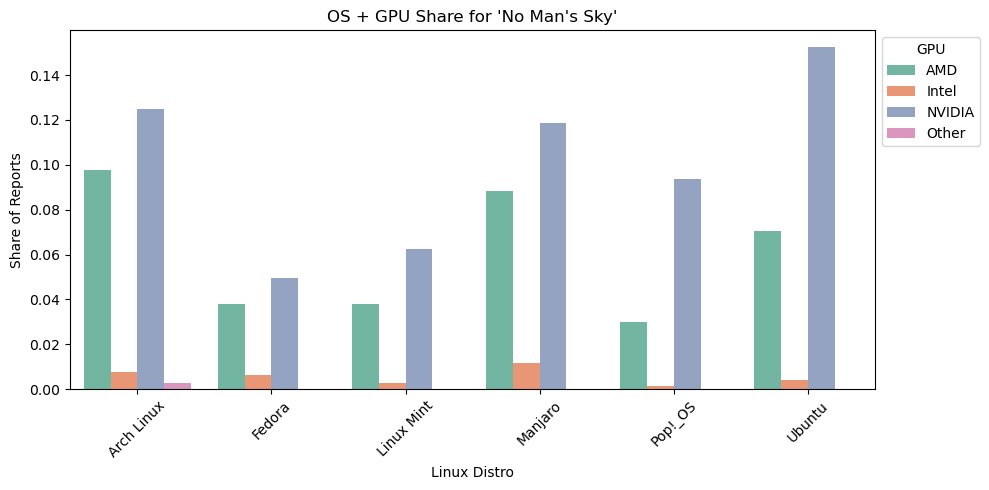

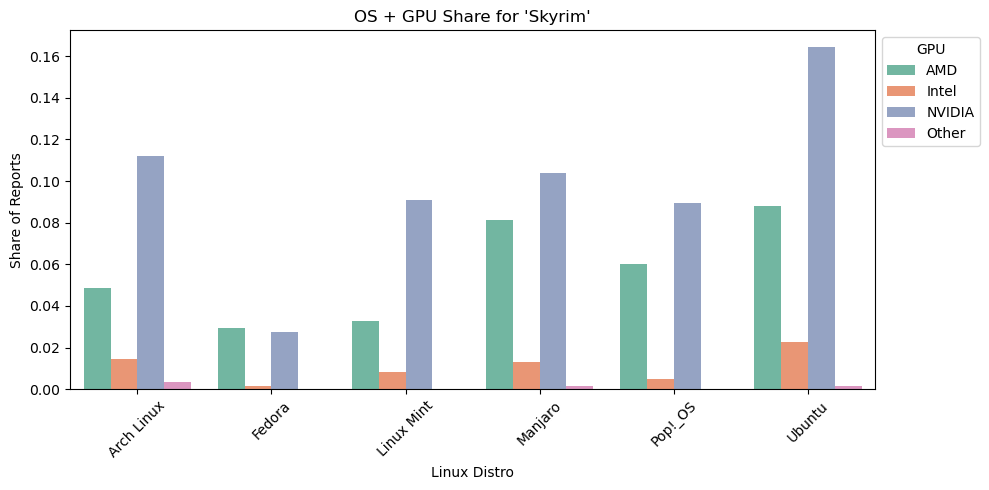

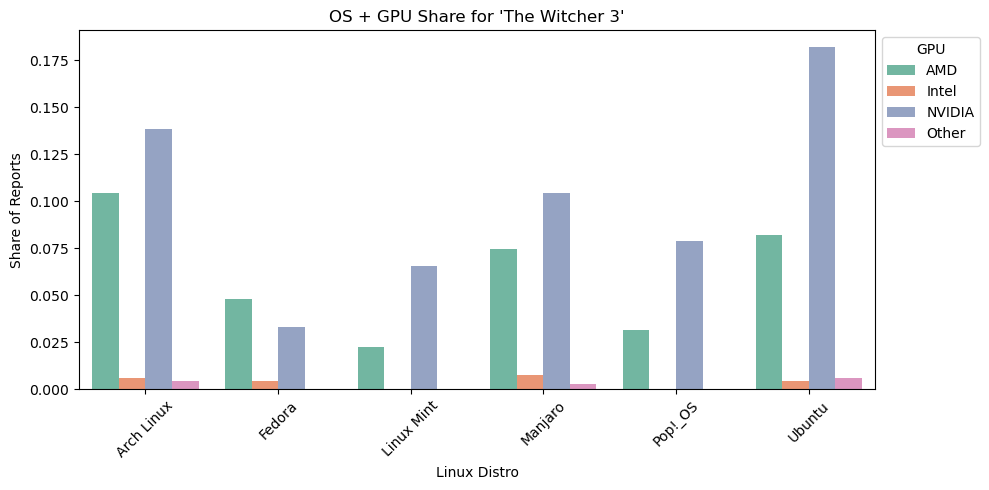

In [12]:
# Normalize game titles (combine Skyrim versions, Witcher variants, etc.)
df['game'] = df['app.title'].str.strip().fillna("")
df['game'] = df['game'].replace({
    "The Elder Scrolls V: Skyrim": "Skyrim",
    "The Elder Scrolls V: Skyrim Special Edition": "Skyrim",
    "The Witcher 3: Wild Hunt": "The Witcher 3",
    "No Man’s Sky": "No Man's Sky",
    "Cyberpunk 2077": "Cyberpunk 2077"
})

selected_games = ["Cyberpunk 2077", "No Man's Sky", "Skyrim", "The Witcher 3"]

# Filter to major distros and target games
focus_distros = ["Arch Linux", "Ubuntu", "Manjaro", "Pop!_OS", "Linux Mint", "Fedora"]
game_gpu_df = df[
    df["game"].isin(selected_games) & 
    df["os_family"].isin(focus_distros) & 
    df["gpu_vendor"].notnull()
]

# Count and normalize by game
combo_distribution = (
    game_gpu_df.groupby(["game", "os_family", "gpu_vendor"])
    .size()
    .reset_index(name="count")
)
combo_distribution["proportion"] = combo_distribution.groupby("game")["count"].transform(lambda x: x / x.sum())


# Plot for each game
for game in selected_games:
    subset = combo_distribution[combo_distribution["game"] == game]
    plt.figure(figsize=(10, 5))
    sns.barplot(data=subset, x="os_family", y="proportion", hue="gpu_vendor", palette="Set2")
    plt.title(f"OS + GPU Share for '{game}'")
    plt.xlabel("Linux Distro")
    plt.ylabel("Share of Reports")
    plt.xticks(rotation=45)
    plt.legend(title="GPU", loc="upper left", bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.show()


## Tinkering and Workarounds Keyword Frequency

This bar chart shows the most frequently mentioned customization tools and tweaks from user-submitted notes.

Glorious Eggroll (GE) and custom Proton builds are by far the most popular.

Launch options, DXVK, and Protontricks are also common.

These tweaks are often used to fix broken games, boost performance, or enable features like DirectX 12 via Vulkan.

This chart reveals that even though Proton has matured, many users still rely on advanced tools to optimize their gaming experience.


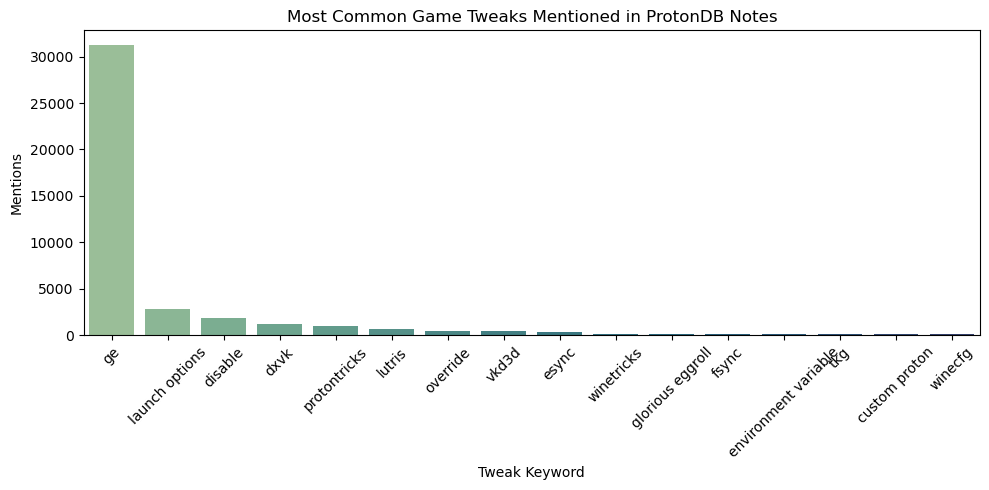

In [13]:
from collections import Counter

# Define keywords to track in user notes
tweak_keywords = [
    "protontricks", "winetricks", "custom proton", "tkg", "ge", "glorious eggroll",
    "dxvk", "vkd3d", "launch options", "lutris", "esync", "fsync",
    "disable", "override", "environment variable", "winecfg"
]

all_notes = " ".join(df[df["responses.concludingNotes"].notnull()]["responses.concludingNotes"].str.lower())
keyword_counts = Counter()

for keyword in tweak_keywords:
    keyword_counts[keyword] = all_notes.count(keyword)

# Convert to DataFrame for plotting
tweak_df = pd.DataFrame.from_dict(keyword_counts, orient="index", columns=["count"]).sort_values(by="count", ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x=tweak_df.index, y=tweak_df["count"], palette="crest")
plt.title("Most Common Game Tweaks Mentioned in ProtonDB Notes")
plt.ylabel("Mentions")
plt.xlabel("Tweak Keyword")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
